This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
figname = '../paper/fig_params'

In [2]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
Using filename= ../data/2019-03-21
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 5000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 1.0, 'contrast': 1.0, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 500, 'dim2': 2000, 'lr': 0.001, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.2, 'momentum': 0.3, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-21', 'seed': 2019, 'N_cv': 4, 'do_compute': True}
Overwriting train.py
2019-03-21T16:14:01+01:00

CPython 3.7.2
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
torch 1.0.1.post2

compiler   : Clang 10.0.0 (cl

In [24]:
%%writefile params.py
import os
import torch
from main import init, MetaML

import sys
opts = dict(filename='../data/2019-03-16', verbose=0, log_interval=0, do_compute=False  if len(sys.argv) > 1 else True)
#opts = dict(filename='debug', verbose=0, log_interval=0)

print(50*'-')
print(' parameter scan')
print(50*'-')

if True:
    args = init(**opts)
    args.filename = '../data/2019-03-19'
    filename_train = args.filename + '_train.pt'
    if not(os.path.isfile(filename_train + '_lock')):
        open(filename_train + '_lock', 'w').close()
        print(50*'-')
        print('Default parameters')
        print(50*'-')
        from where import Where as ML
        from what import WhatNet
        ml = ML(args)
        ml.train(path=filename_train)
        # ml.main(path=args.filename)
        os.remove(filename_train + '_lock')

if True:
    args = init(**opts)
    mml = MetaML(args)
    if torch.cuda.is_available():
        mml.scan('no_cuda', [True, False])

    args = init(**opts)
    mml = MetaML(args)
    mml.scan('bias_deconv', [True, False])

results = {}
    
def update_results(results, parameter, accuracies):
    if not parameter in results.keys(): results[parameter] = dict(value=[], accuracy=[])
    for value in accuracies.keys():
        results[parameter]['value'].append(value)
        results[parameter]['accuracy'].append(accuracies[value][:-1].mean()*100)
    return results
            
for base in [2, 8] if not args.filename == '../data/debug' else [2]:
    print(50*'-')
    print(' base=', base)
    print(50*'-')

    print(50*'-')
    print(' parameter scan : data')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args, base=base)
    for parameter in ['sf_0', 'B_sf', 'offset_std', 'contrast']: # , 'noise'
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        
    print(50*'-')
    print(' parameter scan : network')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['dim1',
                      'bn1_bn_momentum',
                      'dim2',
                      'bn2_bn_momentum',
                      'p_dropout']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(' parameter scan : learning ')
    args = init(**opts)
    mml = MetaML(args, base=base)
    print(50*'-')
    print('Using SGD')
    print(50*'-')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        mml.parameter_scan(parameter)
    print(50*'-')
    print('Using ADAM')
    print(50*'-')
    args = init(**opts)
    args.do_adam = True
    mml = MetaML(args, tag='adam')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(50*'-')
    print(' parameter scan : retina')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['N_theta',
                      'N_azimuth',
                      'N_eccentricity',
                      'rho']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        

Overwriting params.py


In [25]:
%run params.py scan

--------------------------------------------------
 parameter scan
--------------------------------------------------
scanning over bias_deconv = [True, False]
For parameter bias_deconv = True ,  Accuracy=70.5% +/- 0.0%  in 6606.7 seconds
For parameter bias_deconv = False ,  Accuracy=70.3% +/- 0.0%  in 6620.0 seconds
--------------------------------------------------
 base= 2
--------------------------------------------------
--------------------------------------------------
 parameter scan : data
--------------------------------------------------
scanning over sf_0 = [0.1        0.11892071 0.14142136 0.16817928 0.2        0.23784142
 0.28284271 0.33635857 0.4       ]
For parameter sf_0 = 0.100 ,  Accuracy=65.0% +/- 0.3%  in 8965.4 seconds
For parameter sf_0 = 0.119 ,  Accuracy=66.0% +/- 0.1%  in 9037.2 seconds
For parameter sf_0 = 0.141 ,  Accuracy=66.9% +/- 0.3%  in 9129.4 seconds
For parameter sf_0 = 0.168 ,  Accuracy=69.0% +/- 0.3%  in 9363.4 seconds
For parameter sf_0 = 0.200 ,  

<Figure size 432x288 with 0 Axes>

In [26]:
print(accuracies)

{}


In [27]:
results['sf_0']['value'],  results['sf_0']['accuracy']

([0.1,
  0.11892071150027211,
  0.14142135623730953,
  0.16817928305074292,
  0.2,
  0.23784142300054423,
  0.28284271247461906,
  0.33635856610148585,
  0.4,
  0.11892071150027211,
  0.2,
  0.33635856610148585],
 [65.01000000000002,
  65.97500000000001,
  66.90000000000002,
  68.98499999999999,
  70.46000000000001,
  71.16,
  71.61499999999998,
  72.58,
  73.74499999999999,
  65.97500000000001,
  70.46000000000001,
  72.58])

## parameter scan

---> sf_0


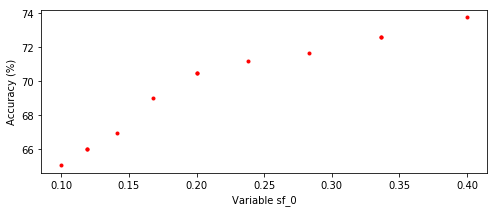

---> B_sf


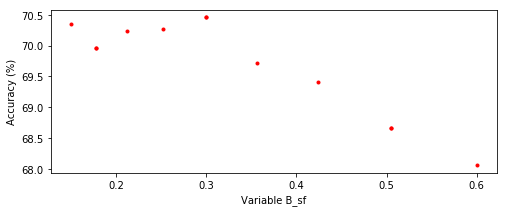

---> offset_std


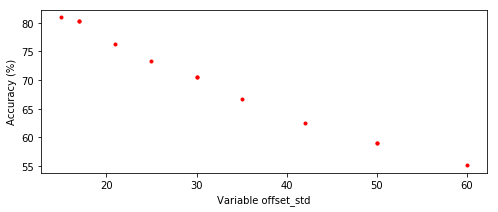

---> contrast


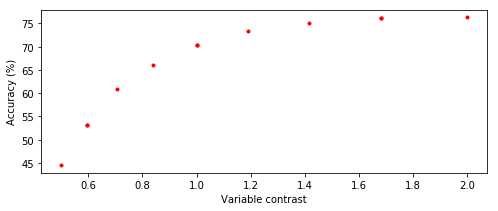

---> dim1


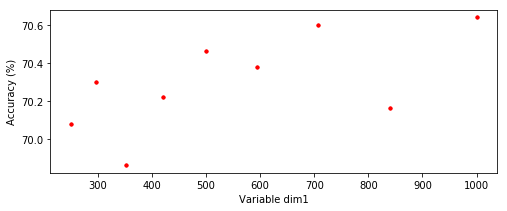

---> bn1_bn_momentum


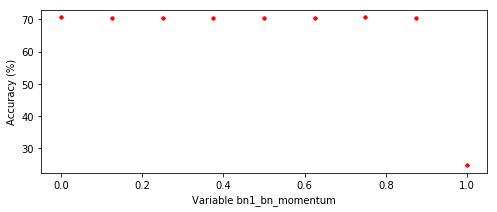

---> dim2


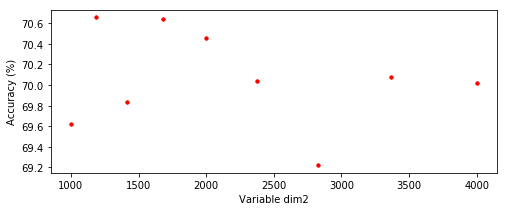

---> bn2_bn_momentum


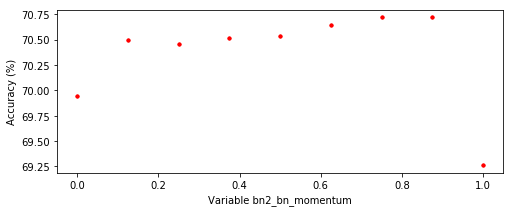

---> p_dropout


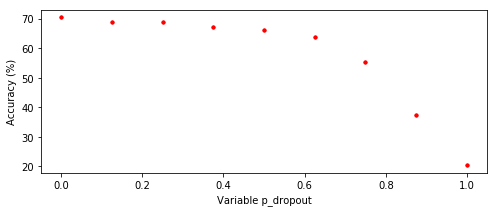

---> lr


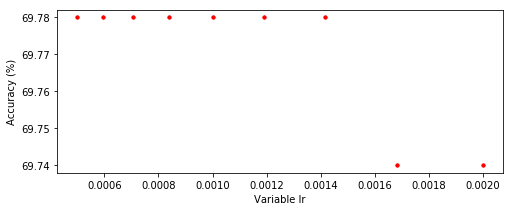

---> momentum


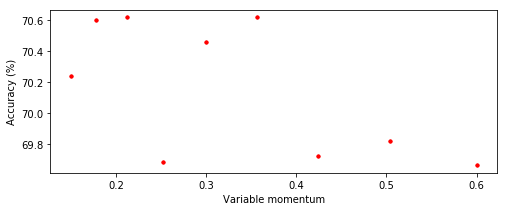

---> minibatch_size


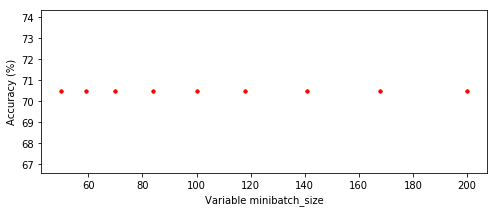

---> epochs


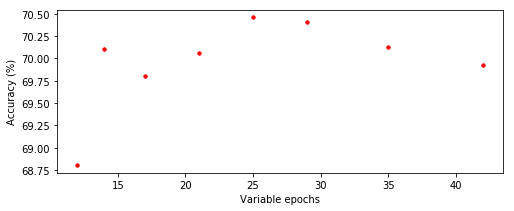

---> N_theta


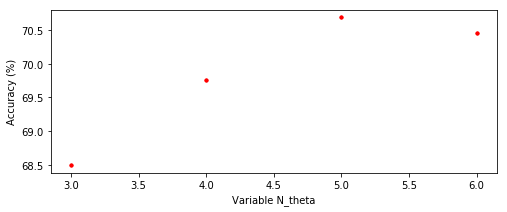

---> N_azimuth


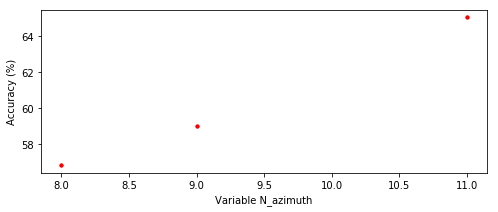

---> N_eccentricity


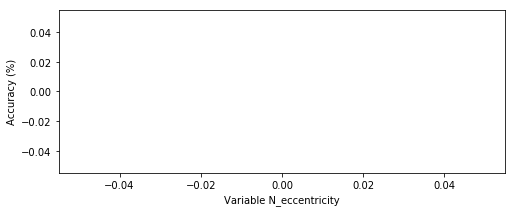

---> rho


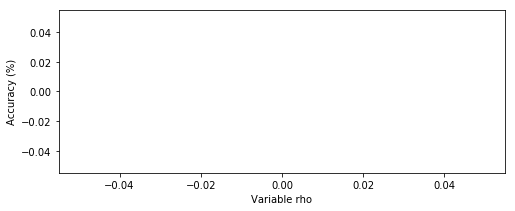

In [28]:
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(results[parameter]['value'], 
            results[parameter]['accuracy'], 'r.')
    plt.xlabel('Variable ' +  parameter)
    plt.ylabel('Accuracy (%)')

    plt.show()

In [29]:
results['sf_0']

{'value': [0.1,
  0.11892071150027211,
  0.14142135623730953,
  0.16817928305074292,
  0.2,
  0.23784142300054423,
  0.28284271247461906,
  0.33635856610148585,
  0.4,
  0.11892071150027211,
  0.2,
  0.33635856610148585],
 'accuracy': [65.01000000000002,
  65.97500000000001,
  66.90000000000002,
  68.98499999999999,
  70.46000000000001,
  71.16,
  71.61499999999998,
  72.58,
  73.74499999999999,
  65.97500000000001,
  70.46000000000001,
  72.58]}

---> sf_0
[0.1, 0.11892071150027211, 0.14142135623730953, 0.16817928305074292, 0.2, 0.23784142300054423, 0.28284271247461906, 0.33635856610148585, 0.4, 0.11892071150027211, 0.2, 0.33635856610148585] [65.01000000000002, 65.97500000000001, 66.90000000000002, 68.98499999999999, 70.46000000000001, 71.16, 71.61499999999998, 72.58, 73.74499999999999, 65.97500000000001, 70.46000000000001, 72.58]


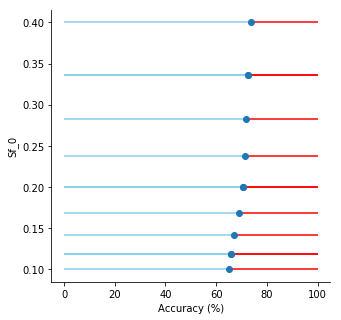

---> B_sf
[0.15, 0.17838106725040814, 0.21213203435596426, 0.25226892457611433, 0.3, 0.3567621345008163, 0.4242640687119285, 0.5045378491522287, 0.6, 0.17838106725040814, 0.3, 0.5045378491522287] [70.35500000000002, 69.96499999999999, 70.23000000000002, 70.265, 70.46000000000001, 69.72500000000001, 69.41, 68.655, 68.05499999999999, 69.96499999999999, 70.46000000000001, 68.655]


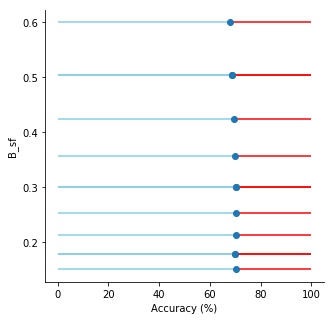

---> offset_std
[15, 17, 21, 25, 30, 35, 42, 50, 60, 17, 30, 50] [80.94000000000003, 80.34, 76.295, 73.29, 70.46000000000001, 66.61500000000001, 62.49, 59.085, 55.115, 80.34, 70.46000000000001, 59.085]


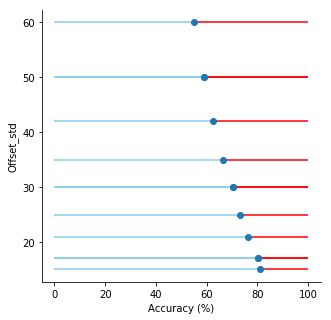

---> contrast
[0.5, 0.5946035575013605, 0.7071067811865476, 0.8408964152537145, 1.0, 1.189207115002721, 1.4142135623730951, 1.681792830507429, 2.0, 0.5946035575013605, 1.0, 1.681792830507429] [44.46, 53.059999999999995, 60.80000000000001, 66.05, 70.46000000000001, 73.38499999999999, 75.15500000000002, 76.165, 76.36, 53.059999999999995, 70.46000000000001, 76.165]


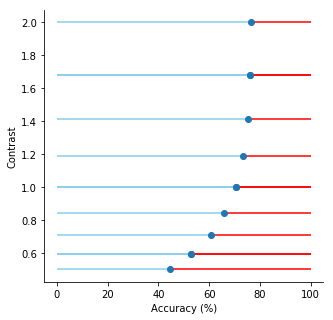

---> dim1
[250, 297, 353, 420, 500, 594, 707, 840, 1000, 250, 297, 353, 420, 500, 594, 707, 840, 1000] [70.08, 70.3, 69.85999999999999, 70.22, 70.46000000000001, 70.38, 70.60000000000001, 70.16, 70.64, 70.08, 70.3, 69.85999999999999, 70.22, 70.46000000000001, 70.38, 70.60000000000001, 70.16, 70.64]


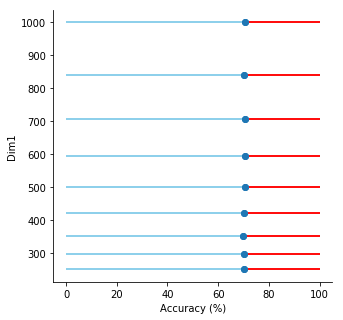

---> bn1_bn_momentum
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0] [70.67999999999999, 70.34, 70.52, 70.5, 70.46000000000001, 70.46000000000001, 70.62, 70.58, 24.58, 70.67999999999999, 70.34, 70.52, 70.5, 70.46000000000001, 70.46000000000001, 70.62, 70.58, 24.58]


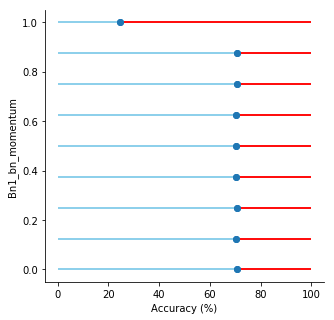

---> dim2
[1000, 1189, 1414, 1681, 2000, 2378, 2828, 3363, 4000, 1000, 1189, 1414, 1681, 2000, 2378, 2828, 3363, 4000] [69.61999999999999, 70.66, 69.84, 70.63999999999999, 70.46000000000001, 70.04, 69.21999999999998, 70.08, 70.02000000000001, 69.61999999999999, 70.66, 69.84, 70.63999999999999, 70.46000000000001, 70.04, 69.21999999999998, 70.08, 70.02000000000001]


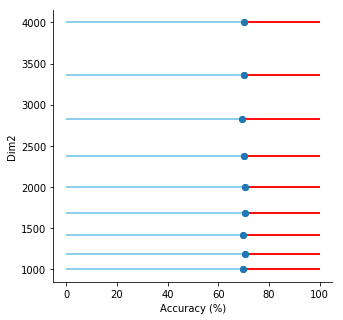

---> bn2_bn_momentum
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0] [69.94, 70.5, 70.46000000000001, 70.52, 70.54, 70.64, 70.72, 70.72, 69.26000000000002, 69.94, 70.5, 70.46000000000001, 70.52, 70.54, 70.64, 70.72, 70.72, 69.26000000000002]


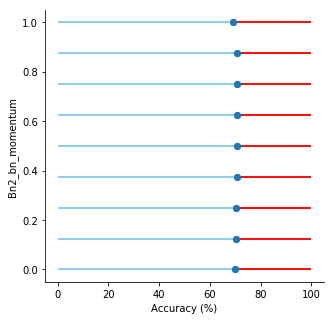

---> p_dropout
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0] [70.46000000000001, 68.79, 68.79, 67.285, 66.19500000000001, 63.75999999999999, 55.230000000000004, 37.285000000000004, 20.34, 70.46000000000001, 68.79, 68.79, 67.285, 66.19500000000001, 63.75999999999999, 55.230000000000004, 37.285000000000004, 20.34]


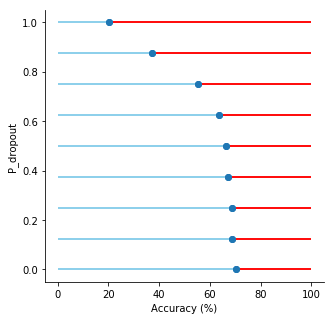

---> lr
[0.0005, 0.0005946035575013605, 0.0007071067811865476, 0.0008408964152537145, 0.001, 0.001189207115002721, 0.0014142135623730952, 0.001681792830507429, 0.002, 0.0005, 0.0005946035575013605, 0.0007071067811865476, 0.0008408964152537145, 0.001, 0.001189207115002721, 0.0014142135623730952, 0.001681792830507429, 0.002] [69.78, 69.78, 69.78, 69.78, 69.78, 69.78, 69.78, 69.74, 69.74, 69.78, 69.78, 69.78, 69.78, 69.78, 69.78, 69.78, 69.74, 69.74]


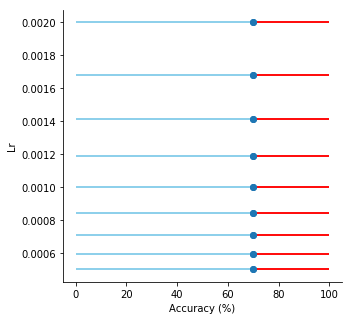

---> momentum
[0.15, 0.17838106725040814, 0.21213203435596426, 0.25226892457611433, 0.3, 0.3567621345008163, 0.4242640687119285, 0.5045378491522287, 0.6, 0.15, 0.17838106725040814, 0.21213203435596426, 0.25226892457611433, 0.3, 0.3567621345008163, 0.4242640687119285, 0.5045378491522287, 0.6] [70.24000000000002, 70.6, 70.62, 69.68000000000002, 70.46000000000001, 70.61999999999999, 69.72, 69.82, 69.66, 70.24000000000002, 70.6, 70.62, 69.68000000000002, 70.46000000000001, 70.61999999999999, 69.72, 69.82, 69.66]


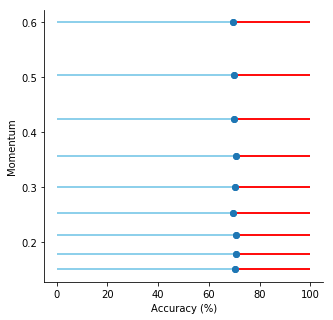

---> minibatch_size
[50, 59, 70, 84, 100, 118, 141, 168, 200, 50, 59, 70, 84, 100, 118, 141, 168, 200] [70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001, 70.46000000000001]


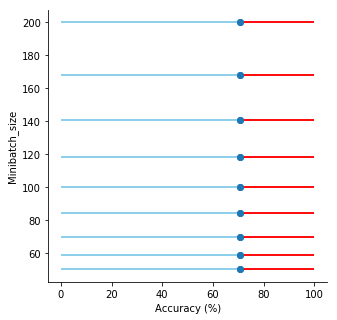

---> epochs
[12, 14, 17, 21, 25, 29, 35, 42, 12, 14, 17, 21, 25, 29, 35, 42] [68.80000000000001, 70.1, 69.8, 70.06, 70.46000000000001, 70.39999999999999, 70.11999999999999, 69.91999999999999, 68.80000000000001, 70.1, 69.8, 70.06, 70.46000000000001, 70.39999999999999, 70.11999999999999, 69.91999999999999]


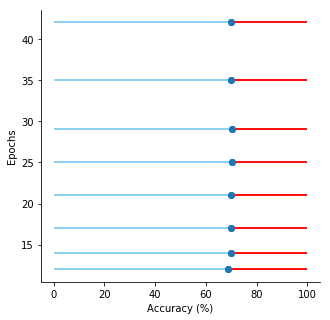

---> N_theta
[3, 4, 5, 6, 3, 4, 5, 6] [68.49000000000001, 69.76500000000001, 70.69, 70.46000000000001, 68.49000000000001, 69.76500000000001, 70.69, 70.46000000000001]


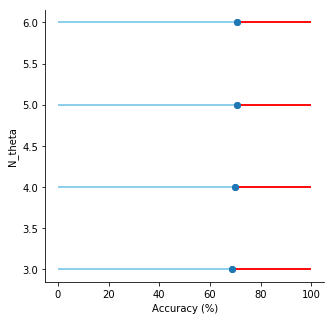

---> N_azimuth
[8, 9, 11, 8, 9, 11] [56.79, 58.99000000000001, 65.035, 56.79, 58.99000000000001, 65.035]


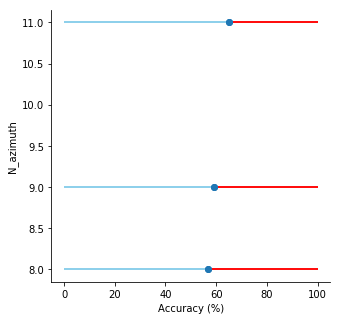

---> N_eccentricity
[] []


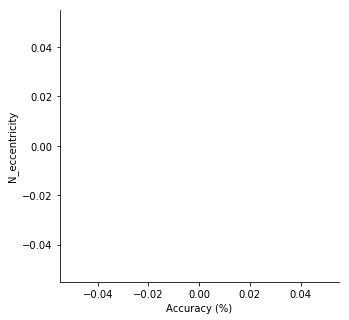

---> rho
[] []


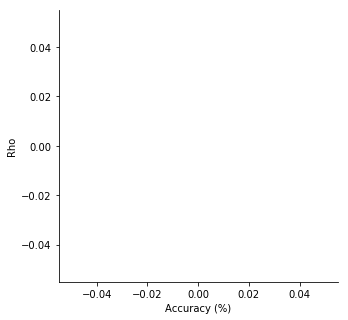

In [32]:
figname = 'accuracy_'
figname = ''

tex = ''
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plt.subplots(figsize=(5, 5))
    print(results[parameter]['value'],  results[parameter]['accuracy'])
    ax.plot(results[parameter]['accuracy'], results[parameter]['value'], "o")
    ax.hlines(y=results[parameter]['value'], xmin=results[parameter]['accuracy'], xmax=100, color='red')
    ax.hlines(y=results[parameter]['value'], xmin=0, xmax=results[parameter]['accuracy'], color='skyblue')

    plt.ylabel(parameter.capitalize())
    #print( results[parameter]['value'] )
    #print( np.min([np.float(k) for k in results[parameter]['value']]))
    #ax.vlines(100, np.min(results[parameter]['value']), np.max(results[parameter]['value']), 'k', label='max')
    plt.xlabel('Accuracy (%)')
    # Only draw spine between the y-ticks
    #ax.spines['left'].set_bounds(-1, 1)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.show()
    if not figname == '':
        fig_dir = './'
        fig_ext = '.pdf'
        fname = figname + parameter + fig_ext
        tex += "\includegraphics[width=.0666\linewidth]{"+ fname + "} \n"
        fig.savefig(os.path.join(fig_dir, fname),
                bbox_inches='tight', pad_inches=0)
print(tex)

# summary


In [31]:
%ls ../data/_tmp_scanning

B_sf__0_037.npy_lock          epochs_adam_42.npy
B_sf__0_063.npy_lock          epochs_adam_50.npy_lock
B_sf__0_106.npy_lock          lr__0_000.npy_lock
B_sf__0_150.npy               lr__0_001.npy
B_sf__0_178.npy               lr__0_002.npy
B_sf__0_212.npy               lr__0_003.npy_lock
B_sf__0_252.npy               lr__0_005.npy_lock
B_sf__0_300.npy               lr__0_008.npy_lock
B_sf__0_357.npy               lr_adam_0_001.npy
B_sf__0_424.npy               lr_adam_0_002.npy
B_sf__0_505.npy               minibatch_size__100.npy
B_sf__0_600.npy               minibatch_size__118.npy
B_sf__0_849.npy_lock          minibatch_size__12.npy_lock
B_sf__1_427.npy_lock          minibatch_size__141.npy
B_sf__2_400.npy_lock          minibatch_size__168.npy
N_azimuth__11.npy             minibatch_size__200.npy
N_azimuth__13.npy_lock        minibatch_size__21.npy_lock
N_azimuth__16.npy_lock        minibatch_size__282.npy_lock
N_azimuth__19.npy_lock        minibatch_size__35.npy_lock
N_azimuth__22.

# post-processing

In [ ]:
!ls  -l {figname}*

In [ ]:
np.logspace(-1, 1, 9, base=2, endpoint=True)

In [ ]:
np.logspace(-1, 1, 9, base=4, endpoint=True)

In [ ]:
np.logspace(-1, 1, 9, base=4)